# h3ronpy documentation

This notebook depends on the libraries from the `requirements.documentation.txt` file being installed.

In [1]:
# imports

from matplotlib import pyplot
import rasterio
from rasterio.plot import show
import numpy as np
import h3.api.numpy_int as h3
from scipy import ndimage
import geopandas as gpd

# increase the plot size
pyplot.rcParams['figure.dpi'] = 300

## Converting raster data to H3

### Prepare a dataset using rasterio

Load an dataset

(<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>)
(284, 327)


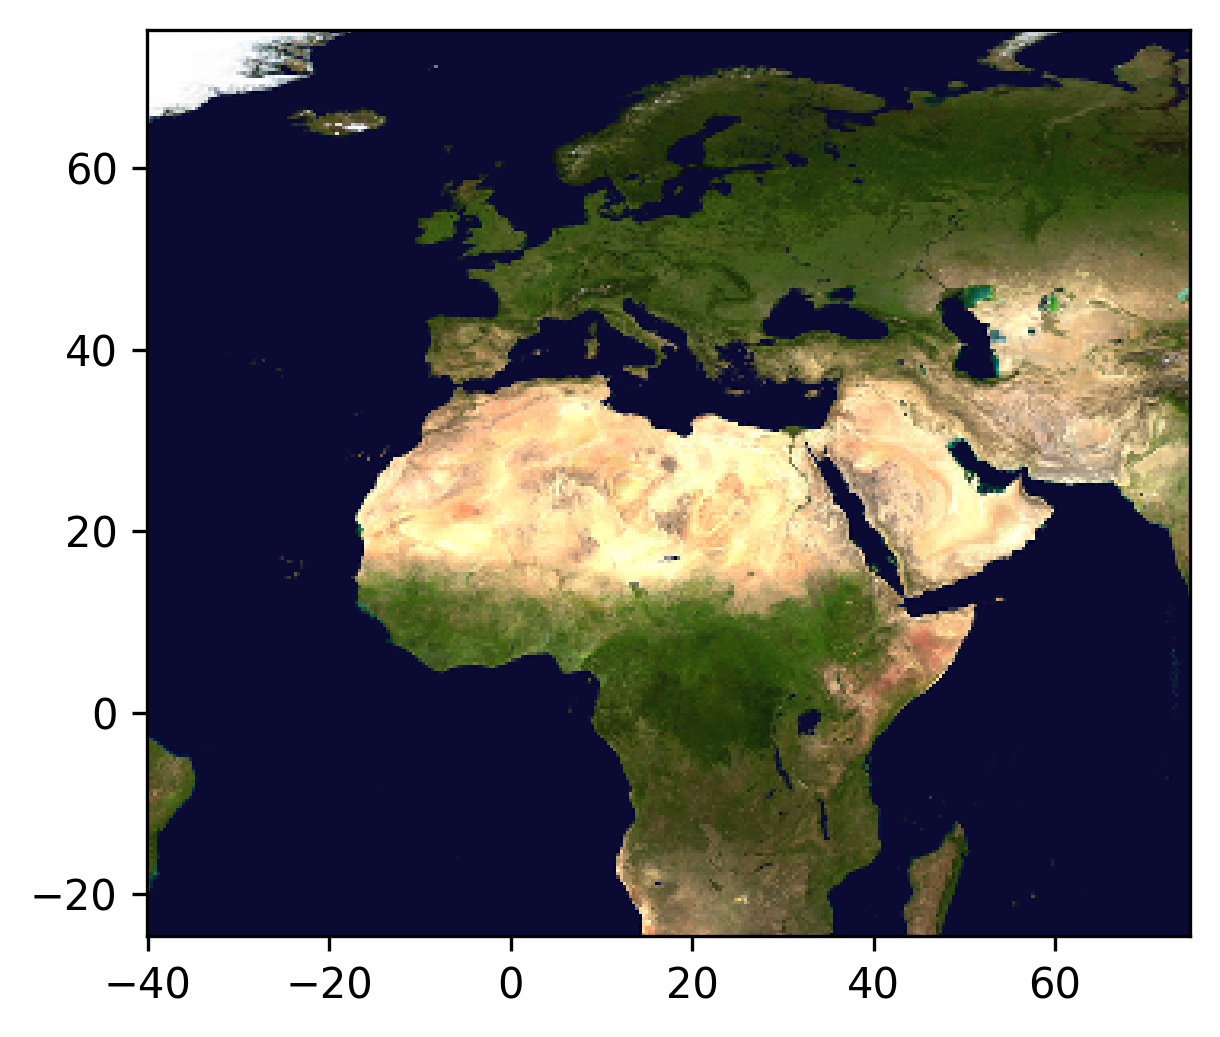

<AxesSubplot:>

In [2]:
src = rasterio.open("../data/europe-and-north-africa.tif")
print(src.colorinterp)

green = src.read(2)
blue = src.read(3)
print(green.shape)

show(src)

Do image processing, like the messy extraction and smoothing of the greenish pixels done here:

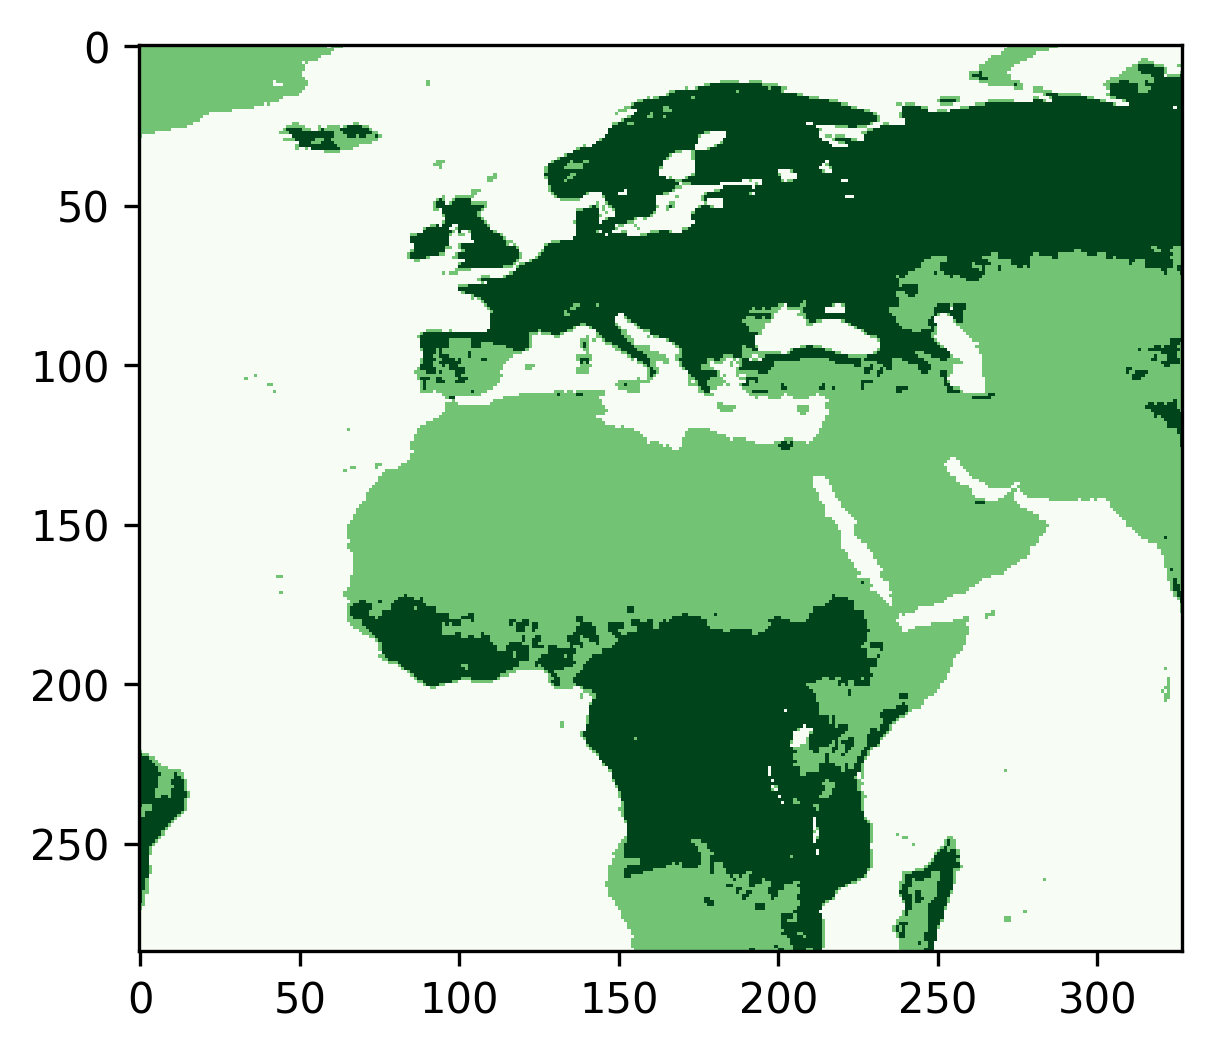

In [3]:
vegetation_mask = (green < 250) & (blue < 50)
ocean_mask = (green >= 6) & (green <= 14) & (blue >= 47) & (blue <= 54)
vegetation_nodata_value = 0

vegetation = np.full(green.shape, 10, dtype="int8")
vegetation[ocean_mask] = vegetation_nodata_value
vegetation[vegetation_mask] = 20
#pyplot.imshow(vegetation, cmap='Greens')

# smooth a bit to remove single pixels
vegetation = ndimage.gaussian_filter(vegetation, sigma=.7)
vegetation[vegetation <= 5] = vegetation_nodata_value
vegetation[(vegetation > 0) & (vegetation < 15)] = 1
vegetation[vegetation >= 15] = 2
vegetation[ocean_mask] = vegetation_nodata_value

vegetation_plot_args = dict(cmap='Greens', vmin=0, vmax=2)

pyplot.imshow(vegetation, **vegetation_plot_args)

In [4]:
vegetation

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

### Convert the raster numpy array to H3

Find the h3 resolution to use. See also the docstrings of the used functions and of the `h3ronpy.raster` module.

In [5]:
from h3ronpy.raster import nearest_h3_resolution

h3_res = nearest_h3_resolution(vegetation.shape, src.transform, search_mode="smaller_than_pixel")
print(f"Using H3 resolution {h3_res}")

Using H3 resolution 5


### ... directly into a pandas (geo-)dataframe:

conversion start
conversion done
plotting ... this may take a bit


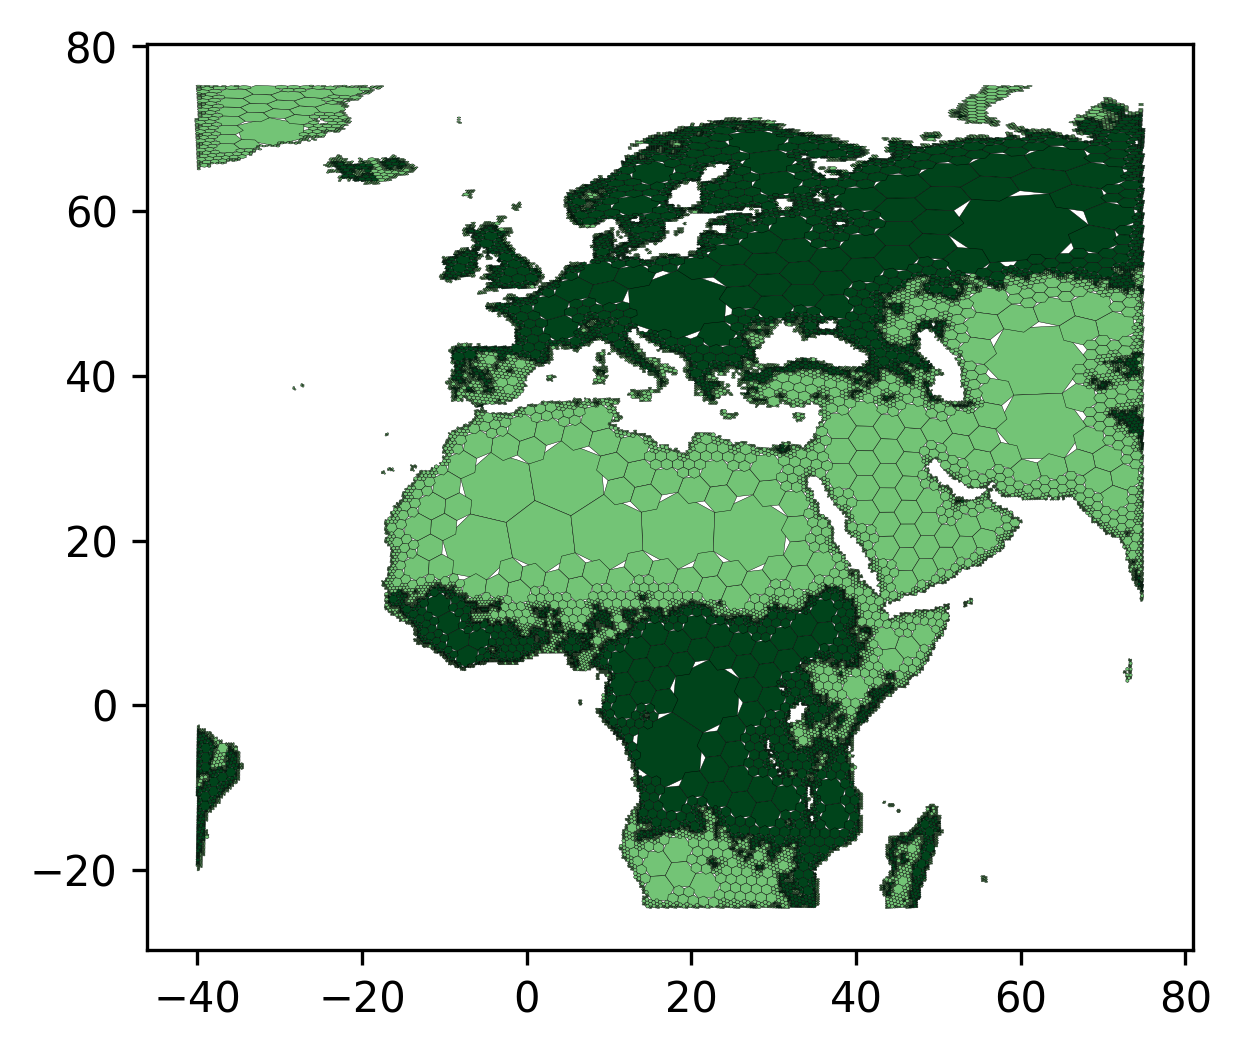

In [6]:
from h3ronpy.raster import raster_to_dataframe

print("conversion start")
vegetation_h3_df = raster_to_dataframe(vegetation, src.transform, h3_res, nodata_value=vegetation_nodata_value, compacted=True, geo=True)
print("conversion done")

print("plotting ... this may take a bit")
vegetation_h3_df.plot(column="value", linewidth=0.1, edgecolor="black", **vegetation_plot_args)
pyplot.show()

### Using GDAL instead of rasterio

To not repeat any steps from above, we just save the processed data using `rasterio` and load it again using `gdal`.

In [7]:
# ... TBW ...

## Converting H3 indexes to vector geometries

The main functionality already exists with the `LinkedPolygons` in the H3 library itself. This library here just integrates this and adds some polish - like the smoothing - around it.

Additionally the polygon objects implement the [python geo interface](https://gist.github.com/sgillies/2217756), so they are compatible to most mapping libraries - see the geopandas plotting below.

<AxesSubplot:>

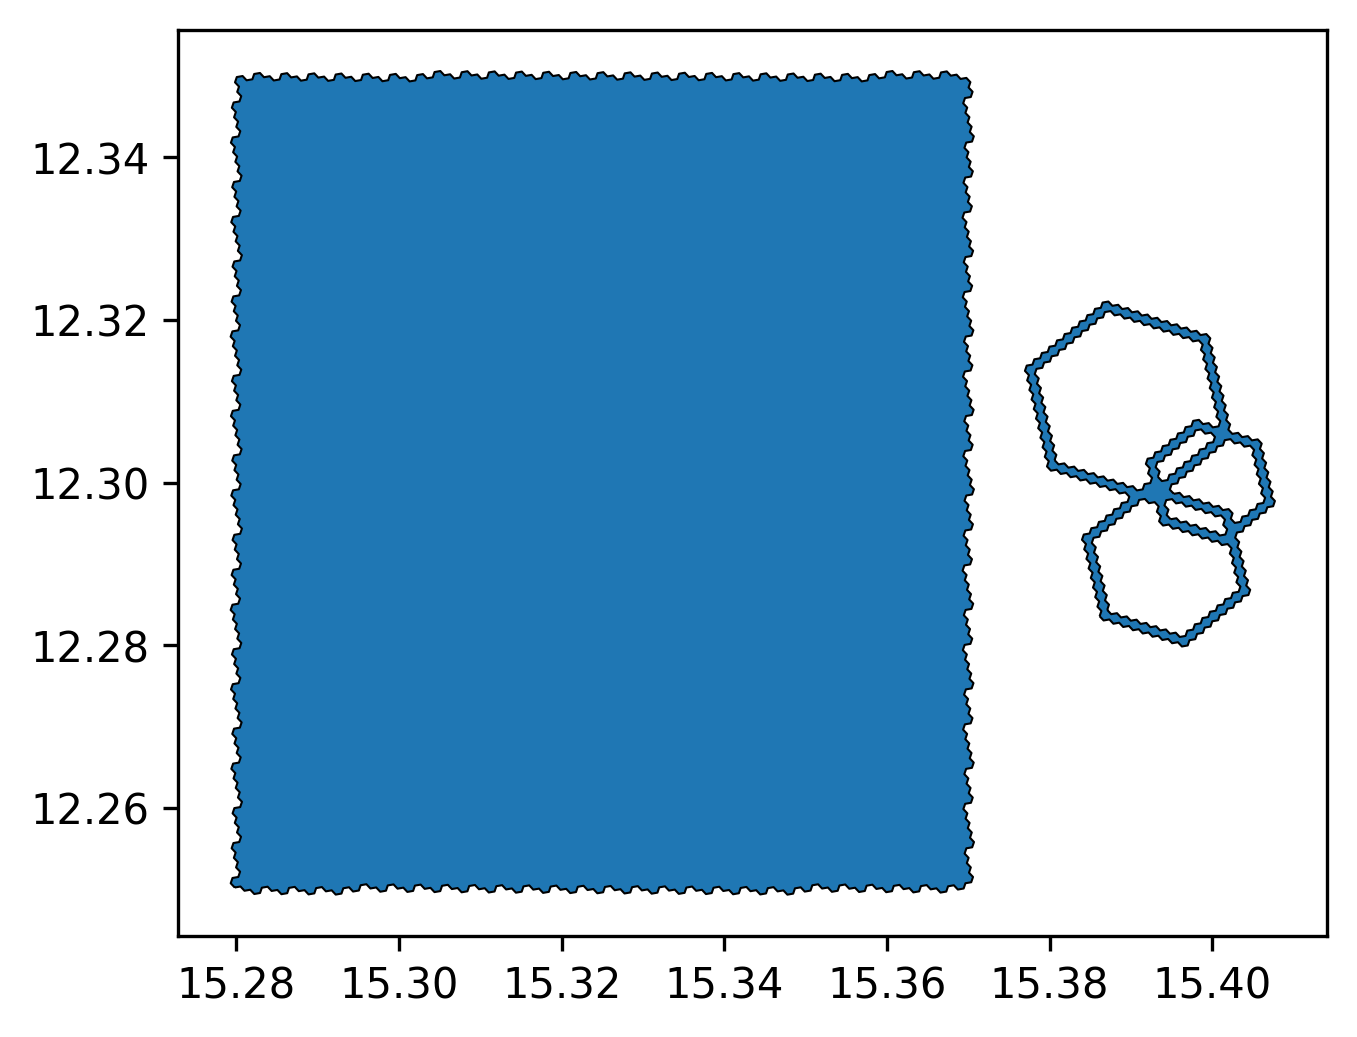

In [8]:
from h3ronpy import Polygon

squares_and_rings = np.concatenate([
    h3.hex_ring(h3.geo_to_h3(12.3, 15.4, 10), 6),
    h3.hex_ring(h3.geo_to_h3(12.31, 15.39, 10), 10),
    h3.hex_ring(h3.geo_to_h3(12.29, 15.395, 10), 8),
    h3.polyfill_polygon([
        (12.25, 15.28),
        (12.25, 15.37),
        (12.35, 15.37),
        (12.35, 15.28), 
        (12.25, 15.28)
    ], 10, lnglat_order=False)
])
sqr_geoms = Polygon.from_h3indexes(squares_and_rings) # returns a list of polygons
gpd.GeoDataFrame({}, geometry=sqr_geoms).plot(edgecolor="black", linewidth=0.5)

For a cleaner look, the generated vector geometries can also be smoothed using a variation of [Chaikins smoothing algorithm](http://www.idav.ucdavis.edu/education/CAGDNotes/Chaikins-Algorithm/Chaikins-Algorithm.html). This includes a non-destructive simplification where the number of vertices gets reduced.

<AxesSubplot:>

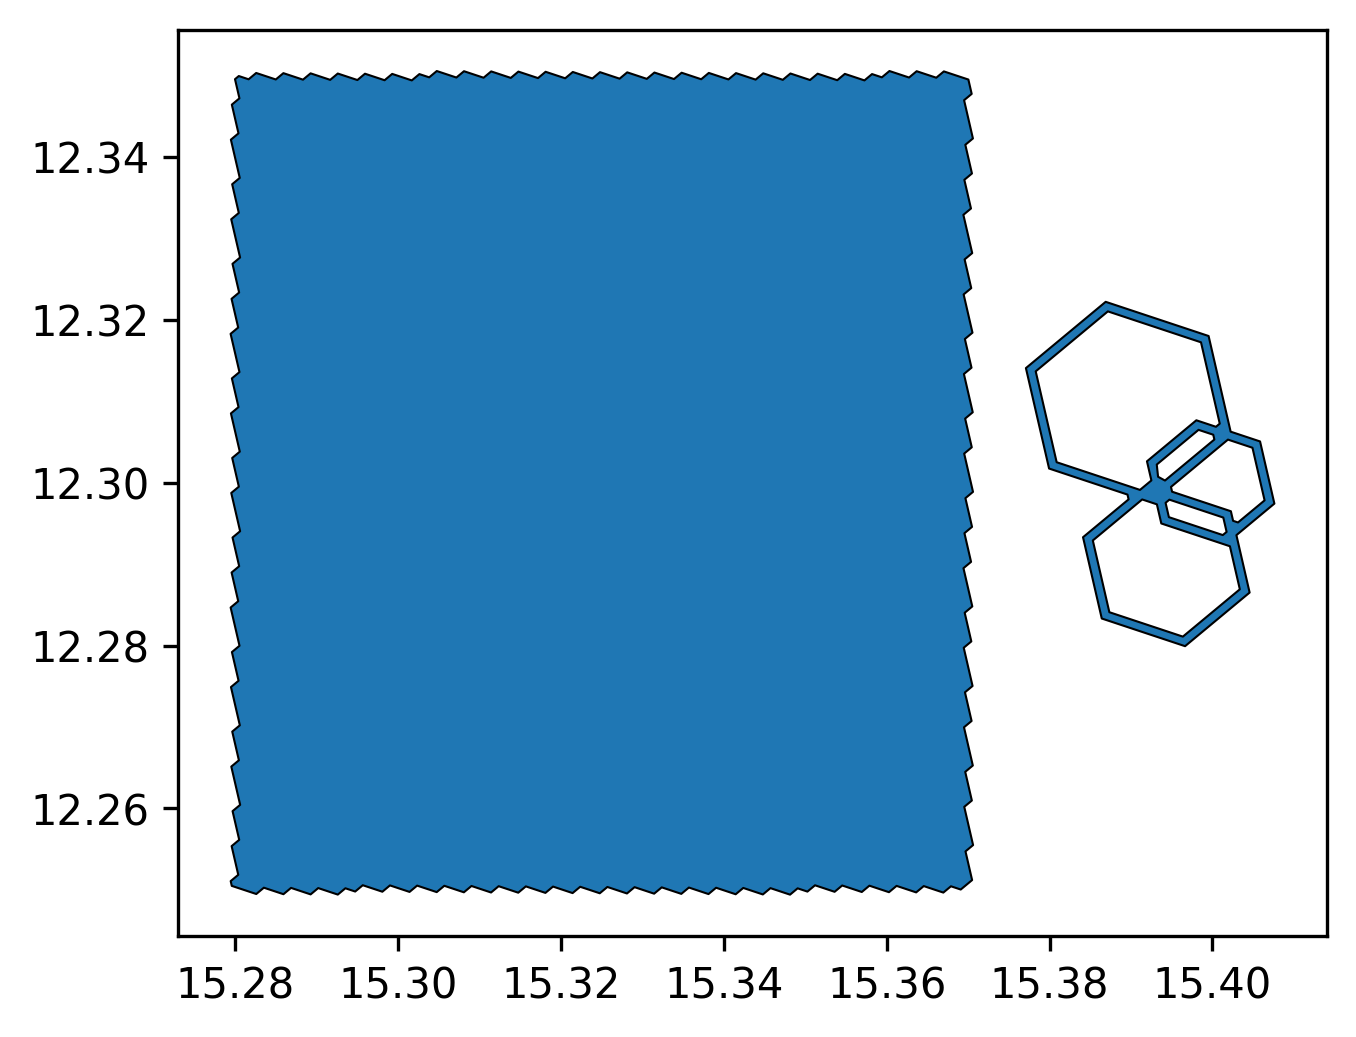

In [9]:
sqr_smoothed = Polygon.from_h3indexes(squares_and_rings, smoothen=True)
gpd.GeoDataFrame({}, geometry=sqr_smoothed).plot(edgecolor="black", linewidth=0.5)

There is also the `align_to_h3_resolution` variant of this which will generate polygons not exceeding the area of a given parent resolution.

Corners will be aligned to the corners of the parent resolution when they are less than an
edge length away from them. This is to avoid gaps when `smoothen` is set to true.

<AxesSubplot:>

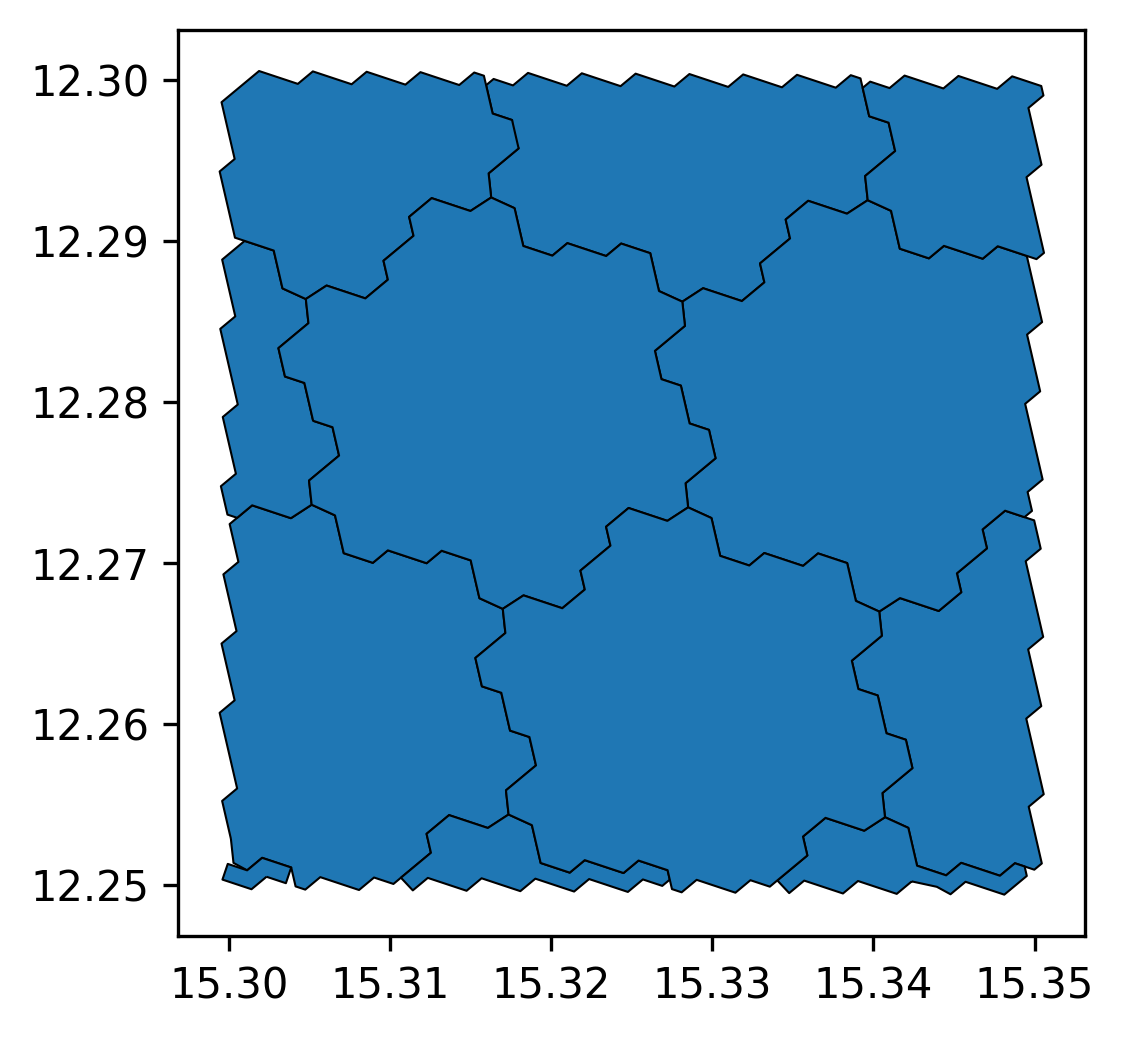

In [10]:
box_indexes = h3.polyfill_polygon([
        (12.25, 15.30),
        (12.25, 15.35),
        (12.30, 15.35),
        (12.30, 15.30), 
        (12.25, 15.30)
], 10)

 # aling the geometries to h3 resolution 2 where complete edges touch. This reduced the number of vertices 
# a fair amount
box_aligned_geoms = Polygon.from_h3indexes_aligned(box_indexes, 7, smoothen=True)
gpd.GeoDataFrame({}, geometry=box_aligned_geoms).plot(edgecolor="black", linewidth=0.5)